In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
from matplotlib import image
from matplotlib import pyplot as plt
from matplotlib.colors import rgb_to_hsv
from skimage.morphology import skeletonize
from skimage.morphology import binary_erosion
from skimage.morphology import binary_dilation
from skimage.feature import canny
import ipywidgets as widgets
from ipywidgets import *
from IPython.display import display
import cv2
import os

In [2]:
data_dir = "../data"

In [3]:
def load_batch():
    for folder in os.listdir(data_dir):
        folder = data_dir + "/" + folder           
        yield folder

In [4]:
# create instance of loader, initialize ui state
vis_batch_loader = load_batch()
current_folder = next(vis_batch_loader)

<IPython.core.display.Javascript object>


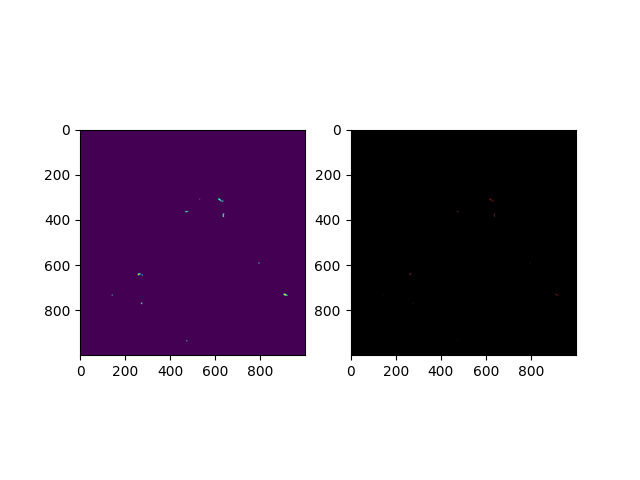

In [9]:
# ui stuff, just run the whole notebook and then you'll get a bunch 
# of buttons under this cell along with a plt plot of the masked image
# buttons will apply various morphological operations to the mask, changing the image
# reset will reset mask to original state
# textbox contains current folder, not changeable

def display_plot(folder):
    lines = np.array([[[0, 0, 0, 0]]])
    mask = np.zeros((1000, 1000), dtype=np.uint8)
    compImg = np.zeros((1000, 1000, 3), dtype=np.uint8)

    # generate mask/composite image
    for imgPath in os.listdir(folder):
        imgPath = folder + "/" + imgPath
        img = cv2.imread(imgPath)
        
        blur = cv2.GaussianBlur(img, (1,1), 0)
        hsv = cv2.cvtColor(blur, cv2.COLOR_BGR2HSV)
        mask1 = cv2.inRange(hsv, (0, 50, 50), (12, 255, 255))
        mask2 = cv2.inRange(hsv, (155, 50, 50), (180, 255, 255))
        mask = cv2.bitwise_or(cv2.bitwise_or(mask1, mask2), mask)

        compImg += (img / len(os.listdir(folder))).astype(np.uint8)
    
    # get lines
    for imgPath in os.listdir(folder):
        imgPath = folder + "/" + imgPath  
        img = cv2.imread(imgPath)
        
        blur = cv2.GaussianBlur(img, (5,5), 0)
        dst = cv2.Canny(blur[:,:,2], 50, 150)
        tmp = cv2.HoughLinesP(dst, 1, np.pi / 180, 17, None, 6, 1)
        contours, hierarchy = cv2.findContours(dst, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
        if tmp is not None:
            lines = np.concatenate((lines, tmp))
            #for i in range(0, len(tmp)):
            #    l = tmp[i][0]
            #    cv2.line(img, (l[0], l[1]), (l[2], l[3]), (0,0,255), 1, cv2.LINE_AA)
        cv2.drawContours(blur, contours, -1, (0,0,255), 1)
        cv2.imshow(imgPath, blur)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        
    if lines is not None:
        for i in range(0, len(lines)):
            l = lines[i][0]
            cv2.line(compImg, (l[0], l[1]), (l[2], l[3]), (0,0,255), 1, cv2.LINE_AA)
    
    axis[1].imshow(cv2.cvtColor(cv2.bitwise_and(compImg, compImg, mask=mask), cv2.COLOR_BGR2RGB))
    #axis[1].imshow(cv2.cvtColor(compImg, cv2.COLOR_BGR2RGB))
    axis[0].imshow(mask)

def next_image(b):
    global current_folder
    current_folder = next(vis_batch_loader)
    if current_folder is not None:
        folder_text.value = current_folder
        display_plot(current_folder)

next_button = widgets.Button(
    description='Next Image',
    disabled=False,
    icon='arrow-right'
)
next_button.on_click(next_image)

folder_text = widgets.Text(
    value=current_folder,
)

figure, axis = plt.subplots(1, 2)
display_plot(current_folder)
display(widgets.HBox([
        next_button,
        folder_text
]))

<IPython.core.display.Javascript object>


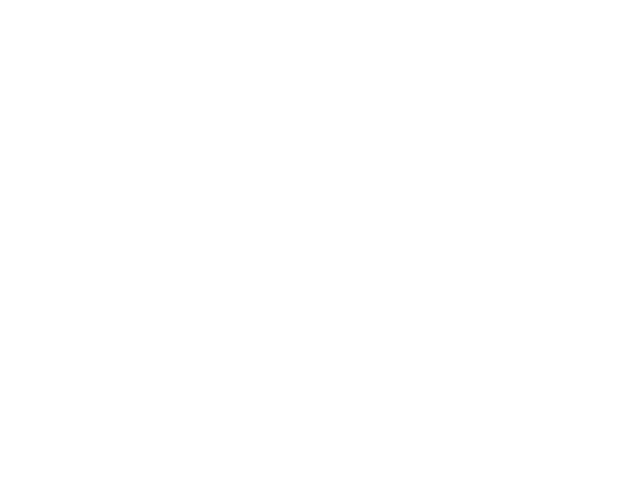

In [11]:
plt.figure()
display_plot("../data/61 tissue1 gNeuN rArl13b bDAPI ZSTACK 0001")